# Applying the VAD method to $V$ and $Z_{DR}$





This notebook shows how to apply the VAD method to the Doppler velocities $Z$ and differential reflectivity $Z_{DR}$ to get parameters of DoT and common orientation. Rennie et al. (2010) and Rennie (2010) applied the VAD method to retrieve parameters of insect flight (DoT, common orientation). 

The data variables are extracted using the code adapted from Lindsay Bennet's  notebook. The VAD method code was written by me, apart from a few lines from L.B.'s notebook, which I have commented with Lindsay's initials (LB).

In [2]:
# First import useful packages

import pyart
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import rcParams
import warnings
import os
import copy

warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)

%matplotlib inline

np.set_printoptions(suppress=True)


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



## 1. Extracting radar variables

In [3]:
# Selecting the date 

date='20170619'

In [4]:
# Path to the data files 

base_directory = '/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/calib_v2/'

# Creating a new directory to save plots

output_directory = os.path.join('/home/users/marta_9/plots/', date)   # 'date' as the title of the directory


In [5]:
# The PPI files are stored in the 'sur' directory, which can be accessed as follows

sur_directory = os.path.join(base_directory,'sur/', date)

# Accessing the PPI files and listing them in order

sur_files = os.listdir(sur_directory)
sur_files.sort()

# Check how many files there are

print(len(sur_files))


# Print the first file 

print(sur_files[1])     # The path shows the time of the scan


215
ncas-mobile-x-band-radar-1_chilbolton_20170619-000747_SUR_v1.nc


In [6]:
# Choose one file. I am choosing file n = 68 at time 07:36:14

n = 68

sur_file = os.path.join(sur_directory, sur_files[n]) 
print(sur_file)

/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/calib_v2/sur/20170619/ncas-mobile-x-band-radar-1_chilbolton_20170619-073614_SUR_v1.nc


We are going to use PPI scans to plot the radar variables.

In [7]:
# Save the PPI scans into a variable called rad

rad = pyart.io.read(sur_file, delay_field_loading = True) 

# True to delay loading of field data from the file until the ‘data’ key in a particular field dictionary is accessed.
# In this case until 'sur_file' is loaded



In [8]:
# Extract and check shape of the radar variables Doppler velocity and ZDR from rad

dopvel = rad.fields['V']['data']  
print(dopvel.shape)              

ZDR = rad.fields['ZDR']['data']
print(ZDR.shape)


(3600, 1000)
(3600, 1000)


In [9]:
# Print the first observations of the series to check for empty values

print(ZDR[:360,:100])
print(dopvel[:360,:100])

# Both datasets present empty values '--'

# It is useful to substitute '--' with nan values for the next steps. This is because some functions substitue empty values with fixed values, e.g. '9e^30'

ZDR = copy.deepcopy(rad.fields['ZDR']['data']) 
dopvel = copy.deepcopy(rad.fields['V']['data'])  # (LB) 

index_zdr = ZDR.mask == True                        # (LB)
index_dopvel = dopvel.mask == True  

ZDR[index_zdr]=np.nan
dopvel[index_dopvel]=np.nan       # (LB)


# Check values again

print(ZDR[:360,:100])


[[-- -3.0456693172454834 8.214173316955566 ... -- -- --]
 [-- -4.305511951446533 5.930708408355713 ... -- -- --]
 [-- -3.833070993423462 -0.28976377844810486 ... -- -- --]
 ...
 [-- -3.911811113357544 5.064566612243652 ... -- -- --]
 [-- -4.148031234741211 -5.092913627624512 ... -- 5.773228168487549 --]
 [-- -4.305511951446533 10.812599182128906 ... -- -- --]]
[[-- -- 2.260629892349243 ... -- -- --]
 [-- -- 2.260629892349243 ... -- -- --]
 [-- -- -12.810235977172852 ... -- -- --]
 ...
 [-- -- -- ... -- -- --]
 [-- -- -- ... -- -- --]
 [-- -- -12.55905532836914 ... -- -- --]]
[[nan -3.0456693172454834 8.214173316955566 ... nan nan nan]
 [nan -4.305511951446533 5.930708408355713 ... nan nan nan]
 [nan -3.833070993423462 -0.28976377844810486 ... nan nan nan]
 ...
 [nan -3.911811113357544 5.064566612243652 ... nan nan nan]
 [nan -4.148031234741211 -5.092913627624512 ... nan 5.773228168487549 nan]
 [nan -4.305511951446533 10.812599182128906 ... nan nan nan]]


In [10]:
# The radar has 10 elevations. They can be stored into an object 'el'

el = rad.elevation['data']
print(el.shape)             # There are 10 elevations * 360 degrees 
                            # therefore the elevation changes every 360 observations

(3600,)


In [11]:
# Extract the azimuth variable

azi = rad.azimuth['data']

In [12]:
# Extact range array

rg = rad.range['data']/1000
print(rg.shape)

(1000,)


## 2. Plotting the radar variables

In [13]:
# Once that all the variables have been defines, we can use the plot_radar function to plot a radar variable (ZDR, V) for a particular elevation(s) and height

# There are 10 different elevations, therefore we can loop each elevation and plot the data for each of them

def plot_radar(min_el, max_el, height, azimuth, variable):
    
    for a in range(min_el, max_el+1):             # Add one to the max elevation, range counts a number less
       
    # The elevation array is a 1D array with 3600 observations
    # The elevation value changes every 360 observations
    
        if a < 10:
            
            elev = el[360*a]                               # Select elevation each 360 observations, e.g. for a = 0, el[0]; for a = 1, el[360]
            
            my_range = height/np.sin(elev*np.pi/180)     # (LB)   # Finding the correspondent range for a specific height and elevation
            range_index = np.where(np.abs(my_range - rg) == np.min(np.abs(my_range-rg)))[0][0]  # (LB)    # Setting a range index
            plt.plot(azi[360*a:360*(a+1)], variable[360*a:360*(a+1), range_index], 'r.', ms = 1)
    # Consider the tenth elevation 
    # el[3600] does not exist, as Python starts counting from 0, the last observation is el[3599]
    
        elif a == 10:  
            
            elev = el[359*a]
            my_range = height/np.sin(elev*np.pi/180)
            range_index = np.where(np.abs(my_range - rg) == np.min(np.abs(my_range-rg)))[0][0]
            plt.plot(azimuth[360*a:360*(a+1)], variable[360*a:360*(a+1), range_index], 'r.', ms = 1)

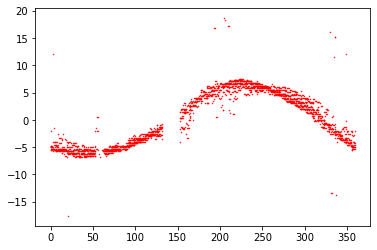

In [14]:
# We can now plot the data from all 10 elevations. At altitude 800 metres, a layer of higher reflectivity was shown in the RHI scan. 

# This indicates a possible higher density of insects. Therefore, we can try this altitude first.
# We want to make 2 plots: one for the Doppler velocities and one for the differential reflectivity 


# First plot the Doppler velocities

plot_radar(0, 10, 0.8, azi, dopvel)   # The insects seems to be adopting a common DoT at all elevations: one peak sine curve


The insects seems to be adopting a common DoT at all elevations. This is indicated by the one peak sine curve.

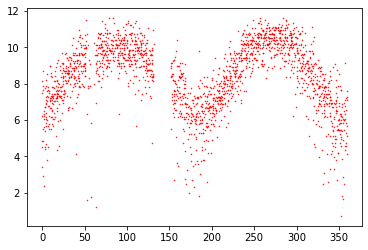

In [26]:
# Now plot the ZDR

plot_radar(0, 10, 0.8, azi, ZDR)   

From the two peaked sine shape of the data, we can deduce that the insects are keeping a common orientation. 

## 3. Fitting a curve to the plots

We can fit a sine curve to the V and ZDR plots to estimate parameters of DoT and common orientation.

In [17]:
# Define a function sine_fit that returns a sine curve with coefficients a, b, c and d. 
# a is the amplitude of the curve, b is the period, c is the phase (horizontal shift), and d is the vertical shift

def sine_fit(x, a, b, c, d):
    return a * np.sin(b* (x - c) ) + d

In [18]:
# We can define some initial parameters to fit the curve to our data

p0 = (1, 1, 1, 1)

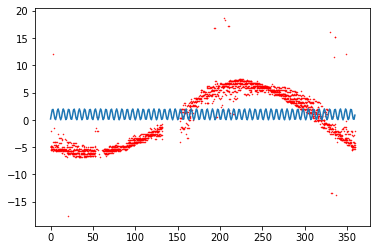

In [19]:
# Plot the data and the sine function

plot_radar(0, 10, 0.8, azi, dopvel)
plt.plot(np.arange(0,360), sine_fit(np.arange(0,360),*p0))

In [20]:
# The parameters can be changes until the curve fits the data

p1 = (6.6, 0.017, 140, 0)

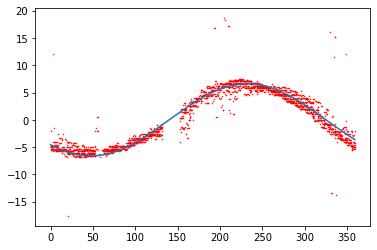

In [21]:
plot_radar(0, 10, 0.8, azi, dopvel)
plt.plot(np.arange(0,360), sine_fit(np.arange(0,360),*p1))

The plot above shows that the DoT paramer is approximately at 225° (x-coordinates of sine curve).

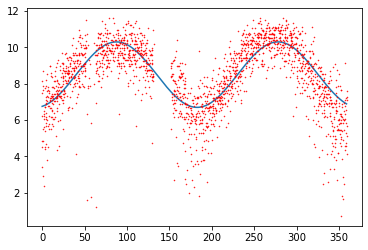

In [25]:
# Now plot the ZDR

p0 = (1.8, 0.033, 40, 8.5)

plt.plot(np.arange(0,360), sine_fit(np.arange(0,360),*p0))
plot_radar(0, 10, 0.8, azi, ZDR)   

To find the parameer that describes the common orientation, in certain cases the $Z_{DR}$ data has to be manipulated. This is when the sine function that fits the $Z_{DR}$ has two peaks of maximum $Z_{DR}$ and two of minimum $Z_{DR}$. 

In our plot above, the minimum $Z_{DR}$ is at 175° and at 360°. It can be assumed that the insects are oriented closer to the DoT; therefore, 175° would be a more reasonable parameter to describe the heading direction of the insetcs than 360°, as it is closer to the DoT (225°). 

However, in other cases, the orientation parameter might be more ambiguous, as the curve might present two minimum points that could both be reasonable estimates. In those cases, some data manipulation should be applied. 


For more details on the data manipulation see Rennie et al. (2010) and the Future Work section on my website. 

## References

Rennie, S., Illingworth, A., Dance, S. and Ballard, S., 2010. The accuracy of Doppler radar wind retrievals using insects as targets. Meteorological Applications, 17(4), pp.419-432.DOI: 10.1002/met.174

Rennie, S., 2013. Common orientation and layering of migrating insects in southeastern Australia observed with a Doppler weather radar. Meteorological Applications, 21(2), pp.218-229. DOI: 10.1002/met.1378